In [2]:
import os
import glob
import uproot
import omegaconf
import matplotlib.pyplot as plt
from termcolor import colored
import yaml

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

In [3]:
def check_condor_log(logfile):
    retcode = -999
    with open(logfile) as f:
        for line in f:
            if 'exit-code' in line:
                retcode = line[-2]
    
    return retcode

In [4]:
class Status:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

    @classmethod
    def success(self, text):
        print(f"{text}: {self.OKGREEN}Success{self.ENDC}")
    
    @classmethod
    def fail(self, text):
        print(f"{text}: {self.FAIL}Fail{self.ENDC}")

    @classmethod
    def running(self, text):
        print(f"{text}: {self.OKBLUE}Running{self.ENDC}")

    @classmethod
    def status(self, text, status):
        if status == 'Fail': self.fail(text)
        if status == 'Success': self.success(text)
        if status == 'Running': self.running(text)


In [5]:
def check_status(job_folder):

    status = 'Fail'

    condor_log = glob.glob(f"{job_folder}/generation*.log")
    stdout_log = glob.glob(f"{job_folder}/generation*.out")
    stderr_log = glob.glob(f"{job_folder}/generation*.out")
    output_rootfile = glob.glob(f"{job_folder}/output*.root")

    # If we have an stdout then job has completed
    if stdout_log and not output_rootfile:
        status = 'Fail'
    elif stdout_log and output_rootfile:
        status = 'Success'
    else:
        status = 'Running'
    
    return job_folder, status

In [6]:
def status(sample_folder):

    job_folders = [p for p in glob.glob(f"{sample_folder}/*") if os.path.isdir(p)]

    status_of_jobs = [check_status(p) for p in job_folders]

    for (job_folder, status) in status_of_jobs:

        if status == "Fail":
            print(os.path.basename(job_folder), colored(status, 'red'))
        if status == 'Success':
            print(os.path.basename(job_folder), colored(status, 'green'))
        if status == 'Running':
            print(os.path.basename(job_folder), colored(status, 'blue'))

    # plt.table(cellText=status_of_jobs,
    #           rowLabels=["Jobs"],
    #         #   rowColours=colors,
    #           colLabels=['Status'])

    return sample_folder


In [7]:
# Create drop down menu to select the simulation run
runs = [p for p in glob.glob("multirun/*") if os.path.isdir(p)];
interact(status, sample_folder=runs);


interactive(children=(Dropdown(description='sample_folder', options=('multirun/2023-03-09_typeII_single_prod_W…

In [8]:
print(colored('red', 'red'))

red


In [9]:
def extract_parameters(job_folder):
    overrides_file = os.path.join(job_folder, '.hydra', 'overrides.yaml')

    overrides = {}
    with open(overrides_file, "r") as stream:
        overrides = yaml.safe_load(stream)
    # omegaconf.OmegaConf.load(overrides_file)

    print(overrides)
    return overrides

In [10]:
job_folders = [p for p in glob.glob("multirun/2023-03-09_typeII_single_prod_WWjj/*") if os.path.isdir(p)]

parameters = []

for f in job_folders:
    parameters.append(extract_parameters(f))


['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=0', 'parameters.MDPP=1300', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-4', 'parameters.MDPP=1100', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-1', 'parameters.MDPP=300', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-6', 'parameters.MDPP=300', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-6', 'parameters.MDPP=700', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-1', 'parameters.MDPP=1900', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=0', 'parameters.MDPP=300', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-1', 'parameters.MDPP=1500', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-6', 'parameters.MDPP=1700', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-6', 'parameters.MDPP=1300', 'batch=True']
['+process=typeII_vbs_boso

In [11]:
params = []
process = ""

for entry in parameters[0]:
    if 'process' in entry:
        process = entry.split('=')[-1]
    if 'parameters' in entry:
        params.append(entry.split("parameters.")[-1].split('=')[0])

print(process, params)

typeII_vbs_bosonic ['log10_vevD', 'MDPP']


Text(0.5, 0, '$M_{\\Delta^{++}}$ [GeV]')

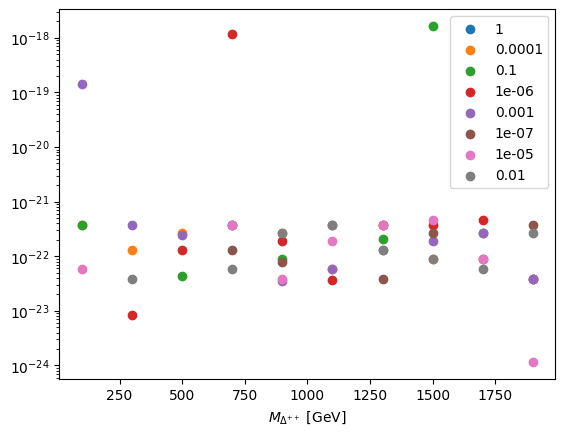

In [15]:
results = {}
failed_results = {}

for folder in job_folders:
    vevd = os.path.basename(folder).split('_')[-1]
    results[vevd] = {'mdpp': [], 'xsec': []}

for folder in job_folders:
    vevd = float(os.path.basename(folder).split('_')[-1])
    mdpp = float(os.path.basename(folder).split('_')[-2])
    xsec = 0
    try:
        metadata = uproot.open(f"{folder}/output.root:metadata")
        xsec = metadata['total_xs'].array(library='np')
        results[str(vevd)]['mdpp'].append(mdpp)
        results[str(vevd)]['xsec'].append(xsec)
    except Exception:
        pass
    

fig, ax = plt.subplots()

for vevd, value in results.items():
    ax.scatter(value['mdpp'], value['xsec'], label=vevd)

ax.legend()
ax.set_yscale('log')
ax.set_xlabel(r"$M_{\Delta^{++}}$ [GeV]")
ax.set_ylabel(r"$\sigma$ (fb)")


